In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !python --version

In [ ]:
# !pip install tensorflow==2.8.2

# !pip list

In [ ]:
!pip3 install -q git+https://github.com/vasudevgupta7/gsoc-wav2vec2@main
!sudo apt-get install -y libsndfile1-dev
!pip3 install -q SoundFile

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1-dev is already the newest version (1.0.28-4ubuntu0.18.04.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# !pip freeze >> requierements.txt


# For Weights and Biases
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras
import numpy as np
import sys

import wave
import copy
import math


from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers import GRU, LSTM, Input, Flatten, Concatenate, Embedding, Convolution1D, Dropout, Bidirectional, Conv2D, MaxPooling2D
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import label_binarize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelBinarizer
from keras.layers import *



#-------------------------------------------
import os
import tensorflow as tf
import tensorflow_hub as hub
from wav2vec2 import Wav2Vec2Config
from wav2vec2 import CTCLoss
import soundfile as sf
from IPython.display import Audio
import random
import pandas as pd
import csv
import numpy as np

config = Wav2Vec2Config()
print("TF version:", tf.__version__)


# For MLOps
import wandb
print("W&B: ", wandb.__version__)
from wandb.keras import WandbCallback

TF version: 2.8.2
W&B:  0.12.19


In [ ]:

import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
# y_true = [[0, 1, 0], [0, 0, 1]]
# y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
# # Using 'auto'/'sum_over_batch_size' reduction type.  
# cce = tf.keras.losses.CategoricalCrossentropy()
# cce(y_true, y_pred).numpy()

In [ ]:
# y_true = [1, 2]
# y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
# # Using 'auto'/'sum_over_batch_size' reduction type.  
# scce = tf.keras.losses.SparseCategoricalCrossentropy()
# scce(y_true, y_pred).numpy()

In [ ]:
import wandb
from wandb.keras import WandbCallback

# Login to W&B
wandb.login()

wandb: Currently logged in as: ruddy. Use `wandb login --relogin` to force relogin


True

In [ ]:
REQUIRED_SAMPLE_RATE = 16000
AUDIO_MAXLEN = 246000
LABEL_MAXLEN = 3
# BATCH_SIZE = 3
# LEARNING_RATE = 5e-5

In [ ]:
def read_txt_file(f):
  with open(f, "r") as f:
    samples = f.read().split("\n")
    samples = {s.split()[0]: " ".join(s.split()[1:]) for s in samples if len(s.split()) > 0}
  return samples

def read_flac_file(file_path):
  with open(file_path, "rb") as f:
      audio, sample_rate = sf.read(f)
  if sample_rate != REQUIRED_SAMPLE_RATE:
      raise ValueError(
          f"sample rate (={sample_rate}) of your files must be {REQUIRED_SAMPLE_RATE}"
      )
  file_id = os.path.split(file_path)[-1][:-len(".wav")]
  return {file_id: audio}


def fetch_sound_text_mapping(data_dir):
  all_files = os.listdir(data_dir)

  flac_files = [os.path.join(data_dir, f) for f in all_files if f.endswith(".wav")]
  txt_files = [os.path.join(data_dir, f) for f in all_files if f.endswith(".txt")]

  txt_samples = {}
  for f in txt_files:
    txt_samples.update(read_txt_file(f))

  speech_samples = {}
  for f in flac_files:
    speech_samples.update(read_flac_file(f))

  assert len(txt_samples) == len(speech_samples)

  
  samples = [(speech_samples[file_id], txt_samples[file_id]) for file_id in speech_samples.keys() if len(speech_samples[file_id]) < AUDIO_MAXLEN]
  not_samples = [(file_id, speech_samples[file_id], txt_samples[file_id]) for file_id in speech_samples.keys() if len(speech_samples[file_id]) > AUDIO_MAXLEN]
  
  return samples, not_samples


def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cols = subset if subset is not None else df.columns.tolist()

    for col in tqdm(cols):
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()

            # test if column can be converted to an integer
            treat_as_int = str(col_type)[:3] == 'int'
            if int_cast and not treat_as_int:
                treat_as_int = check_if_integer(df[col])

            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
data_dir = "/content/drive/MyDrive/Colab_Notebooks/Wav2Vec2_Project/data/new_wavs/"
all_files = os.listdir(data_dir)

flac_files = [f for f in all_files if f.endswith(".wav")]
print(len(flac_files))
txt_files = [f for f in all_files if f.endswith(".txt")]
print(len(txt_files))

print("Transcription files:", txt_files, "\nSound files:", flac_files)

file_id = random.choice([f[:-len(".wav")] for f in flac_files])
flac_file_path, txt_file_path = os.path.join(data_dir, f"{file_id}.wav"), os.path.join(data_dir, "only_labels.txt")

print("Text Transcription:", read_txt_file(txt_file_path)[file_id], "\nAudio:")
Audio(filename=flac_file_path)

samples, not_samples = fetch_sound_text_mapping(data_dir)
print(len(samples))
print(len(not_samples))

5531
3
Transcription files: ['wav+trans_labels.txt', 'only_labels222222.txt', 'only_labels.txt'] 
Sound files: ['Ses05M_script03_1_M015.wav', 'Ses05M_script03_1_M016.wav', 'Ses05M_script03_1_M018.wav', 'Ses05M_script03_1_M020.wav', 'Ses05M_script03_1_M021.wav', 'Ses05M_script03_1_M022.wav', 'Ses05M_script03_1_M023.wav', 'Ses05M_script03_1_M024.wav', 'Ses05M_script03_1_M025.wav', 'Ses05M_script03_1_M026.wav', 'Ses05M_script03_1_M027.wav', 'Ses05M_script03_1_M028.wav', 'Ses05M_script03_1_M029.wav', 'Ses05M_script03_1_M030.wav', 'Ses05M_script03_1_M031.wav', 'Ses05M_script03_1_M032.wav', 'Ses05M_script03_1_M033.wav', 'Ses05F_impro08_F000.wav', 'Ses05F_impro08_F001.wav', 'Ses05F_impro08_F002.wav', 'Ses05F_impro08_F003.wav', 'Ses05F_impro08_F004.wav', 'Ses05F_impro08_F005.wav', 'Ses05F_impro08_F007.wav', 'Ses05F_impro08_F008.wav', 'Ses05F_impro08_F009.wav', 'Ses05F_impro08_F010.wav', 'Ses05F_impro08_F011.wav', 'Ses05F_impro08_F012.wav', 'Ses05F_impro08_F014.wav', 'Ses05F_impro08_F015.wav', 

In [ ]:
no_list =[]
for i in range(len(not_samples)):
  #print(ccc[i][0][1:5])
  no_list.append(str(not_samples[i][0]))
  
print(len(no_list))
# no_list

60


In [ ]:
#len(samples[0][0])

hlong = 0

for i in range(len(samples)):
  a = len(samples[i][0])
  if a > hlong: hlong = a 

print("max vector length: ", hlong)

max vector length:  245599


In [ ]:
# for i in range(len(samples)):
  # print(i, len(samples[i][0]))

In [ ]:
X = []
Y = []

for audio, label in samples:
  X.append(audio)
  Y.append(label)


print(type(X))
print(type(Y))
print(len(X))
print(len(Y))

<class 'list'>
<class 'list'>
5471
5471


In [ ]:
for i in range(len(X)): 
  gh = np.pad(X[i], (0, int(AUDIO_MAXLEN - len(X[i]))), mode = "constant")
  X[i] = gh

print(len(X[0]))
print(len(Y[0]))

246000
1


In [ ]:
X = np.array(X)

print(type(X))
print(type(X[0]))
print(X[0])
print()

#-----------------
YY = []

for i in Y:
   a = i[0] 
   YY.append(a)

Y = np.array(YY)

Y = np.array(Y)

#------------------
print(type(Y))
print(type(Y[0]))
print(Y[0])
print()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[0.00198364 0.00250244 0.0032959  ... 0.         0.         0.        ]

<class 'numpy.ndarray'>
<class 'numpy.str_'>
1



In [ ]:
dfX = pd.DataFrame(X)
dfX

,0,1,2,3,4,5,6,7,8,9,...,245990,245991,245992,245993,245994,245995,245996,245997,245998,245999
0,0.001984,0.002502,0.003296,0.003723,0.003815,0.003357,0.002411,0.001709,0.001038,0.000580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001709,0.001709,0.001770,0.002350,0.003143,0.003601,0.004242,0.004517,0.003967,0.003876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.000885,-0.001007,-0.001648,-0.002411,-0.002655,-0.002594,-0.002594,-0.002228,-0.001709,-0.001740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.007294,0.007721,0.007996,0.007782,0.007538,0.007690,0.007751,0.007202,0.006500,0.005920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001190,0.001801,0.003052,0.002991,0.003937,0.004364,0.003143,0.003265,0.003448,0.003357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5466,-0.001038,-0.001068,-0.001892,-0.002533,-0.003235,-0.003632,-0.003418,-0.003387,-0.003204,-0.002869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5467,0.004517,0.004059,0.003204,0.003662,0.003601,0.003174,0.003510,0.003479,0.003662,0.003784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5468,-0.000244,0.000793,0.001556,0.002014,0.002075,0.002441,0.003387,0.003815,0.003601,0.003418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5469,-0.001404,-0.000763,-0.000641,-0.000305,-0.000092,-0.000671,-0.000854,-0.000214,0.000214,0.000610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dfY = pd.DataFrame(Y)
dfY

,0
0,1
1,1
2,1
3,1
4,1
...,...
5466,2
5467,0
5468,2
5469,2


# **speech_training**

In [ ]:
# a = tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)
# # a = tf.constant(a, shape=[4, 4])
# print(a)

In [ ]:
# import numpy as np
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_train = X[:3838]
X_test = X[3838:]
y_train = Y[:3838]
y_test = Y[3838:]


print(X_train.shape)
print(X_test.shape)
# print(y_test)

print(y_train.shape)
print(y_test.shape)


(3838, 246000)
(1633, 246000)
(3838,)
(1633,)


In [ ]:
y_train = list(map(int, y_train))
y_test = list(map(int, y_test))
print(y_train)
print(y_test)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 0, 0, 2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 3, 3, 3, 3, 3, 2, 3, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# from tensorflow.keras.utils import to_categorical 

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

# count_classes = y_test.shape[1]
# print(count_classes)

In [ ]:
pretrained_layer = hub.KerasLayer("https://tfhub.dev/vasudevgupta7/wav2vec2/1", trainable=True)

# -----------------------------------------------------------------------------------------------

inputs = tf.keras.Input(shape=(AUDIO_MAXLEN,))
print(inputs.shape)
hidden_states = pretrained_layer(inputs)
print(hidden_states.shape)

hidden_states = tf.keras.layers.Flatten()(hidden_states)
print(hidden_states.shape)

den1 = tf.keras.layers.Dense(64, activation="relu")(hidden_states)
den1 = tf.keras.layers.Dropout(0.5)(den1)

# den2 = tf.keras.layers.Dense(64, activation="relu")(den1)
# den2 = tf.keras.layers.Dropout(0.3)(den2)

# den3 = tf.keras.layers.Dense(64, activation="relu")(den2)
# den3 = tf.keras.layers.Dropout(0.5)(den3)

outputs = tf.keras.layers.Dense(4, activation='softmax')(den1)
print(outputs.shape)


# ----------------------------------------------------------------------------
model = tf.keras.Model(inputs=inputs, outputs=outputs)
# print(model)




model.summary()

(None, 246000)
(None, 768, 768)
(None, 589824)
(None, 4)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 246000)]          0         
                                                                 
 keras_layer (KerasLayer)    (None, 768, 768)          94371712  
                                                                 
 flatten (Flatten)           (None, 589824)            0         
                                                                 
 dense (Dense)               (None, 64)                37748800  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Tota

In [ ]:
#  "loss_function": "sparse_categorical_crossentropy(from_logits=True)",
#  "metrics": [keras.metrics.SparseCategoricalAccuracy(name="acc")]

# Initialize wandb with project
run = wandb.init(project ='Sp_W2V_clean_AA', 
                 config={ #. include hyperparmeters and metadat
                         "learning_rate": 1e-5,
                         "epochs": 100,
                         "batch_size": 4,
                         "loss_fn": "sparse_categorical_crossentropy",
                         "architecture": "wav2vec2.0(for_speech)",
                         "dataset": "IEMOCAP",
                         "metrics":  ["acc"]                         
}) 

config = wandb.config  # We'll use this to configure our experiment

In [ ]:
# optimizer=keras.optimizers.Adam(config.learning_rate)
# model.compile(optimizer, config.loss_fn, 
#               config.metrics)

In [ ]:
# model.compile(
#   optimizer=tf.keras.optimizers.Adam(5e-5),
#   loss=keras.losses.CategoricalCrossentropy(),
#   metrics=[keras.metrics.CategoricalAccuracy(name="acc")]
# )

In [ ]:
# model.compile(
#     optimizer=keras.optimizers.RMSprop(),  # Optimizer
#     # Loss function to minimize
#     loss=keras.losses.SparseCategoricalCrossentropy(),
#     # List of metrics to monitor
#     metrics=[keras.metrics.SparseCategoricalAccuracy()],
# )

In [ ]:
model.compile(
  optimizer=keras.optimizers.SGD(config.learning_rate),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
# hist = model.fit(X_train, y_train, epochs=config.epochs, verbose=1, batch_size=config.batch_size,
#                  validation_data=(X_test, y_test), callbacks=[WandbCallback()])

# # model.fit(X_train, y_train, epochs=200, verbose=20)

In [ ]:
hist = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, shuffle = True,
                 validation_data=(X_test, y_test), 
                 callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


  6/960 [..............................] - ETA: 11:33 - loss: 1.6517 - acc: 0.1250WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3104s vs `on_train_batch_end` time: 0.3479s). Check your callbacks.


960/960 [==============================] - 824s 843ms/step - loss: 1.3144 - acc: 0.3510 - val_loss: 1.1958 - val_acc: 0.4464 - _timestamp: 1656469891.0000 - _runtime: 833.0000
Epoch 2/100
960/960 [==============================] - 806s 839ms/step - loss: 1.2087 - acc: 0.4237 - val_loss: 1.1321 - val_acc: 0.4746 - _timestamp: 1656470696.0000 - _runtime: 1638.0000
Epoch 3/100
960/960 [==============================] - 804s 837ms/step - loss: 1.1641 - acc: 0.4682 - val_loss: 1.0419 - val_acc: 0.5340 - _timestamp: 1656471500.0000 - _runtime: 2442.0000
Epoch 4/100
960/960 [==============================] - 803s 837ms/step - loss: 1.1291 - acc: 0.4742 - val_loss: 1.0030 - val_acc: 0.5664 - _timestamp: 1656472304.0000 - _runtime: 3246.0000
Epoch 5/100
960/960 [==============================] - 804s 837ms/step - loss: 1.1032 - acc: 0.5034 - val_loss: 0.9946 - val_acc: 0.5762 - _timestamp: 1656473108.0000 - _runtime: 4050.0000
Epoch 6/100
960/960 [==============================] - 803s 837ms/st

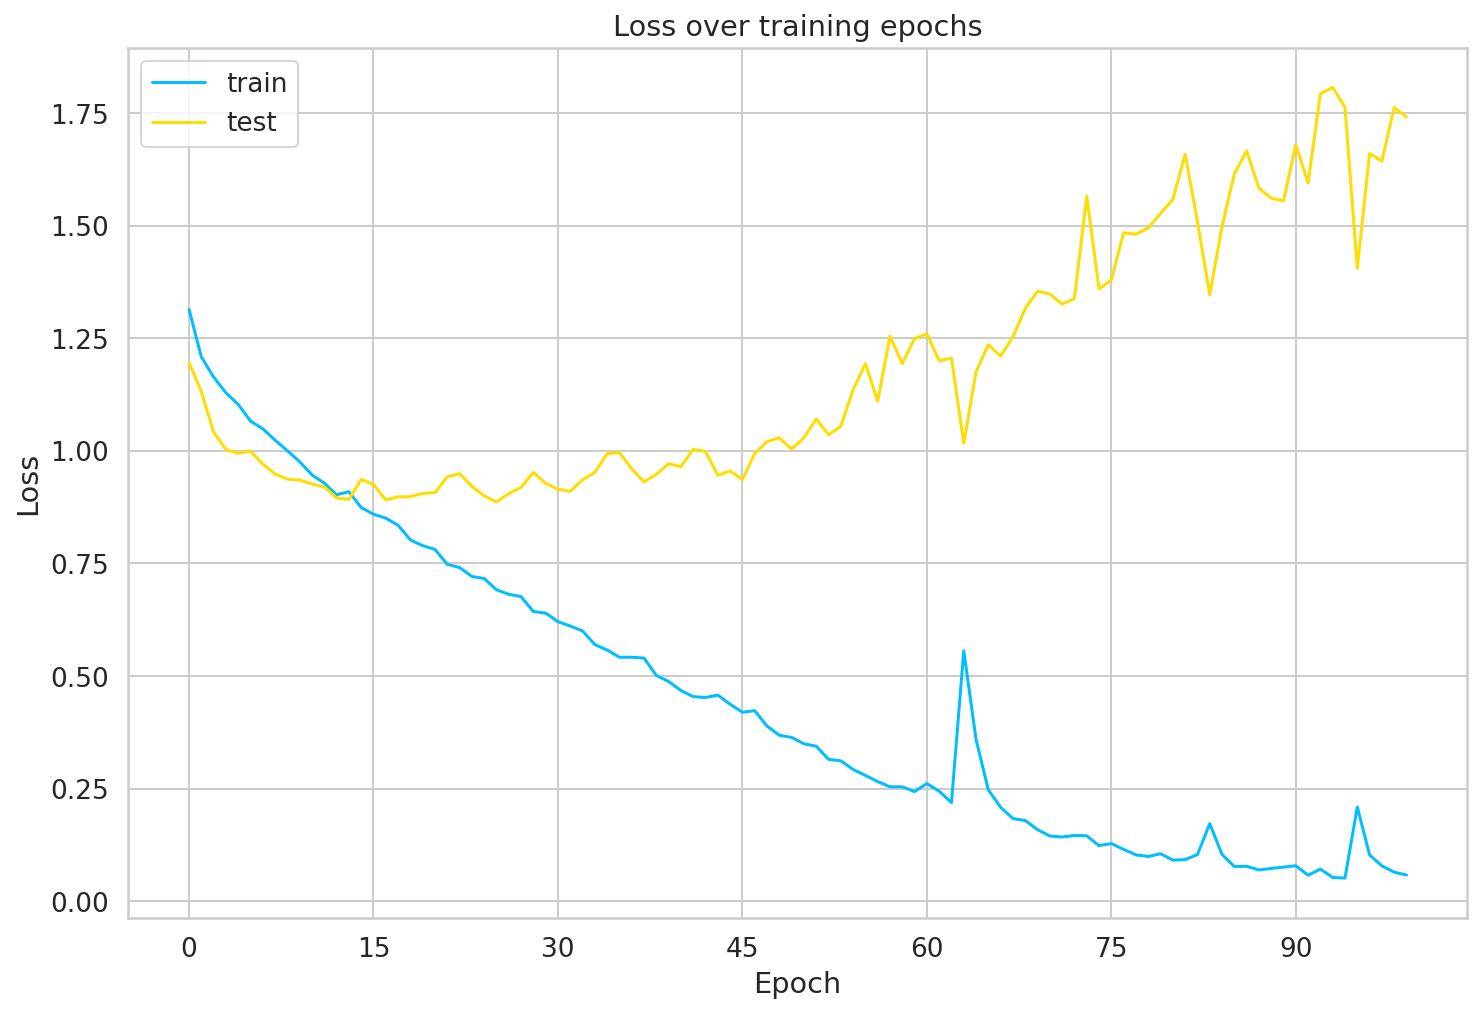

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(hist.history['loss'])
ax.plot(hist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

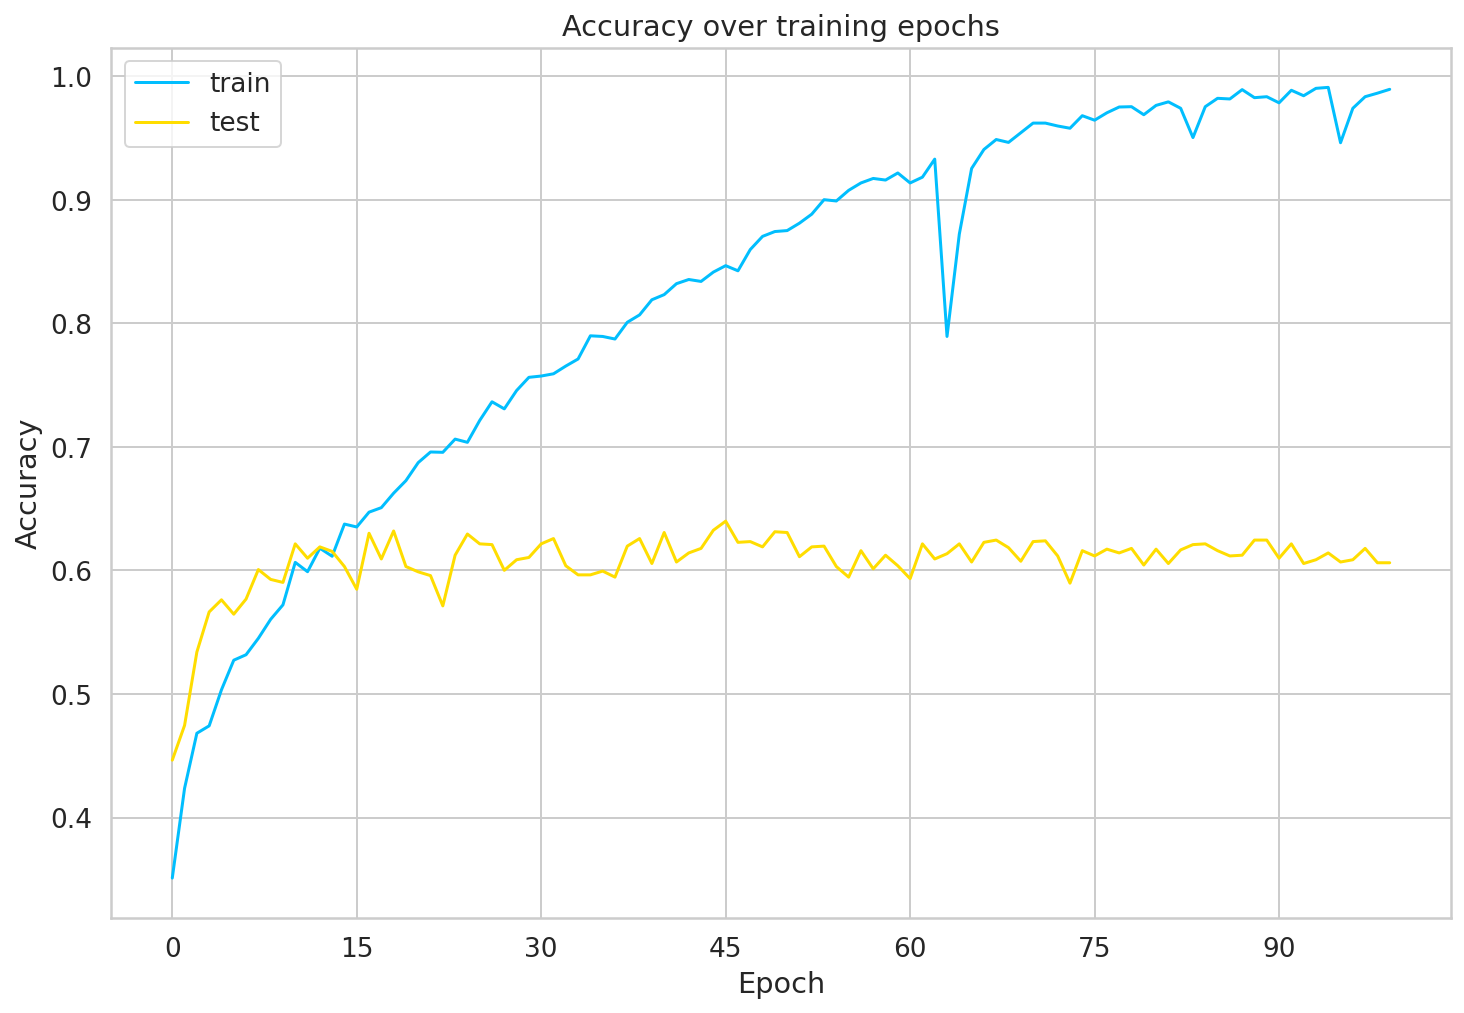

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(hist.history['acc'])
ax.plot(hist.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
train_acc = model.evaluate(X_train, y_train)
test_acc = model.evaluate(X_test, y_test)

print("train acc", train_acc)
print("test acc", test_acc)

InternalError: ignored

In [ ]:
y_pred = model.predict(X_train).argmax(axis=-1)

In [ ]:
print(classification_report(y_test, y_pred, target_names=classes))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
#print(cm) 
#print(df_cm)

# Normalize CM
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#print(norm_cm)

df_norm_cm = pd.DataFrame(norm_cm, index=classes, columns=classes)
#print(df_norm_cm)

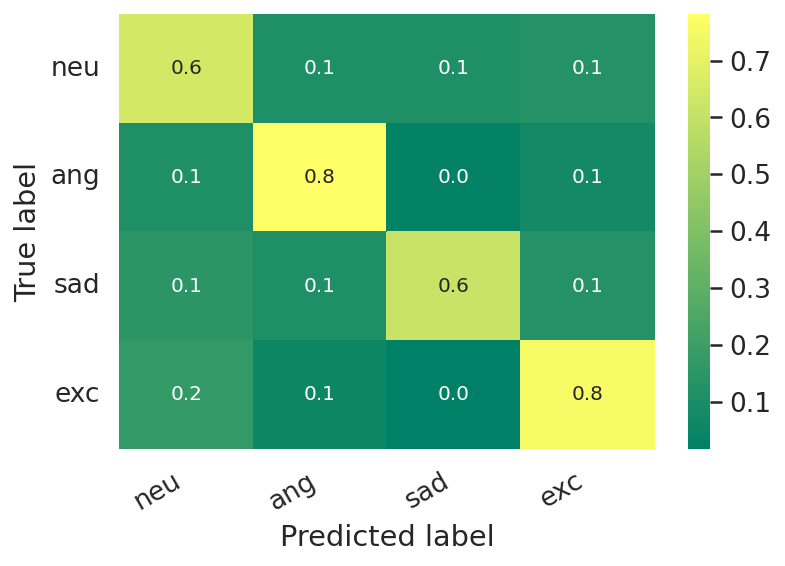

In [ ]:
hmap = sns.heatmap(df_norm_cm, annot=True, fmt="0.1f", cmap="summer")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# **Use wandb.log for custom metrics**
Here, we log the error rate on the test set. 

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Error Rate: ', round((1 - accuracy) * 100, 2))

# With wandb.log, we can easily pass in metrics as key-value pairs.
wandb.log({'Test Error Rate': round((1 - accuracy) * 100, 2)})

run.finish()

In [ ]:
# from wav2vec2 import Wav2Vec2Processor
# tokenizer = Wav2Vec2Processor(is_tokenizer=True)
# processor = Wav2Vec2Processor(is_tokenizer=False)

# def preprocess_speech(audio):
#   audio = tf.constant(audio, dtype=tf.float32)
#   return processor(tf.transpose(audio))

# def preprocess_text_2(text):
#   return tf.constant([0], dtype=tf.int32)

In [ ]:
# XXX = []
# YYY = []

# for audio, label in samples:
#   XXX.append(preprocess_speech(audio))
#   YYY.append(preprocess_text_2(label))

# print(type(XXX))
# print(type(YYY))

In [ ]:

# X = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Wav2Vec2_Project/odd.csv", chunksize=10000) 
# print(type(X))

<class 'pandas.io.parsers.readers.TextFileReader'>


In [ ]:
# X.get_chunk(0)

,0.001983642578125,0.00250244140625,0.0032958984375,0.00372314453125,0.003814697265625,0.00335693359375,0.002410888671875,0.001708984375,0.00103759765625,0.000579833984375,...,0.0.129947,0.0.129948,0.0.129949,0.0.129950,0.0.129951,0.0.129952,0.0.129953,0.0.129954,0.0.129955,0.0.129956


In [ ]:
# XX = [X[0]]
# XX = np.array(XX)

# print(type(XX))
# print(type(XX[0]))

# for i in range(1,5471):
#   XX = np.append(XX, [X[i]], axis=0)

# print(type(XX))
# print(type(XX[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# X = [[0,0,0]]

# # print(X)
# # print(type(X))

# X = np.array(X)
# X = np.append(X, [[6, 7, 8]], axis=0)

# print(X)

# X = np.append(X,[[6, 7, 8]], axis=0)

# print(X)
# print(type(X))
# print(type(X[0]))

[[0 0 0]
 [6 7 8]]
[[0 0 0]
 [6 7 8]
 [6 7 8]]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
X, Y = [], []

X, Y = np.array(X), np.array(Y)

for audio, label in samples:
  X = np.append(X, audio)
  Y = np.append(Y, label)

# for audio, label in samples:
#   X.append(audio)
#   Y.append(label)

In [ ]:
print(type(X))
print(type(X[0]))
print(X[0])
print()

print(type(Y))
print(type(Y[0]))
print(Y[0])
print()

<class 'numpy.ndarray'>
<class 'numpy.float64'>
0.001983642578125

<class 'numpy.ndarray'>
<class 'numpy.str_'>
1



In [ ]:
# import csv 
# with open('/content/drive/MyDrive/Colab_Notebooks/Wav2Vec2_Project/wave2vec_tokenized_weights.csv', 'w', newline ='') as file:    
#     writer = csv.writer(file) 
#     writer.writerows(X)

# import csv 
# with open('/content/drive/MyDrive/Colab_Notebooks/Wav2Vec2_Project/wave2vec_tokenized_weights.csv', 'w', newline ='') as file:    
#     writer = csv.writer(file) 
#     writer.writerows(Y) 

#------------------------------------------------------------------------------------------------------
# import pandas

# # Load the CSV 
# dataframe = pandas.read_csv("/content/drive/MyDrive/Colab_Notebooks/Wav2Vec2_Project/odd.csv", header=None)
# dataset = dataframe.values

# # Split into input (X) and output (last column)
# X = dataset[:,0:246000]
# # Y = dataset[:,4]

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [ ]:
print(type(X_train))
print(type(X_train[0]))
print(X_train[0])
print()

print(type(X_test))
print(type(X_test[0]))
print(X_test[0])
print()

print(type(y_train))
print(type(y_train[0]))
print(y_train[0])
print()

print(type(y_test))
print(type(y_test[0]))
print(y_test[0])
print()

In [ ]:
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import GRU, LSTM, Input, Flatten, Concatenate, Bidirectional, Conv1D


def gru_model1(optimizer='Adam'):
    model = Sequential()

    model.add(Dense(64, activation='relu', input_shape=(246000,)))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = gru_model1()
model.summary()

In [ ]:
hist = model.fit(X_train, y_train, 
                 batch_size=1, epochs=1, verbose=1, shuffle = True,
                 validation_data=(X_test, y_test)) 

In [ ]:
from wav2vec2 import Wav2Vec2Processor
tokenizer = Wav2Vec2Processor(is_tokenizer=True)
processor = Wav2Vec2Processor(is_tokenizer=False)

def preprocess_text(text):
  label = tokenizer(text)
  return tf.constant(label, dtype=tf.int32)

def preprocess_speech(audio):
  audio = tf.constant(audio, dtype=tf.float32)
  return processor(tf.transpose(audio))


def preprocess_text_2(text):
  return tf.constant([0], dtype=tf.int32)

In [ ]:
def inputs_generator():
  for speech, text in samples:
    yield preprocess_speech(speech), preprocess_text(text)